In [4]:
import pandas as pd

# Ruta al archivo CSV
file_path = r"C:\Users\ignac\Downloads\BBDD_calls.csv"

# Leer el archivo usando separador ';' y solo columnas necesarias
df = pd.read_csv(file_path, sep=';', usecols=['Fecha', 'Llamadas_Predecidas', 'Llamadas_Recibidas', 'Es_Cyber'])

# Mostrar columnas y primeras filas
print("Columnas reales:")
print(df.columns.tolist())
display(df.head())

# Reemplazar nulos con 0 (excepto en la fecha)
cols_to_fill = ['Llamadas_Predecidas', 'Llamadas_Recibidas', 'Es_Cyber']
df[cols_to_fill] = df[cols_to_fill].fillna(0)

# Convertir Fecha a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True, errors='coerce')

# Es_Cyber a binario
df['Es_Cyber'] = df['Es_Cyber'].astype(str).str.upper().replace({'SI': 1, 'NO': 0}).astype(int)

# Convertir numéricas
df['Llamadas_Predecidas'] = pd.to_numeric(df['Llamadas_Predecidas'], errors='coerce').fillna(0).astype(int)
df['Llamadas_Recibidas'] = pd.to_numeric(df['Llamadas_Recibidas'], errors='coerce').fillna(0).astype(int)

# Verificación
print("\nDatos limpios:")
display(df.head())
print("\nTipos de datos:")
print(df.dtypes)

# Guardar como pickle
pkl_path = r'C:\Users\ignac\Python\call-center-app\data\data_limpia_llamadas.pkl'
df.to_pickle(pkl_path)
print(f"\n✅ Archivo guardado como '{pkl_path}'")


Columnas reales:
['Fecha', 'Llamadas_Predecidas', 'Llamadas_Recibidas', 'Es_Cyber']


,Fecha,Llamadas_Predecidas,Llamadas_Recibidas,Es_Cyber
0,01-06-2021,5328.0,9800.0,SI
1,02-06-2021,5114.0,7687.0,SI
2,03-06-2021,4906.0,5895.0,NO
3,04-06-2021,4534.0,5045.0,NO
4,05-06-2021,1757.0,2228.0,NO



Datos limpios:


C:\Users\ignac\AppData\Local\Temp\ipykernel_5360\1036754782.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Es_Cyber'] = df['Es_Cyber'].astype(str).str.upper().replace({'SI': 1, 'NO': 0}).astype(int)


,Fecha,Llamadas_Predecidas,Llamadas_Recibidas,Es_Cyber
0,2021-06-01,5328,9800,1
1,2021-06-02,5114,7687,1
2,2021-06-03,4906,5895,0
3,2021-06-04,4534,5045,0
4,2021-06-05,1757,2228,0



Tipos de datos:
Fecha                  datetime64[ns]
Llamadas_Predecidas             int32
Llamadas_Recibidas              int32
Es_Cyber                        int32
dtype: object

✅ Archivo guardado como 'C:\Users\ignac\Python\call-center-app\data\data_limpia_llamadas.pkl'


In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import holidays
import matplotlib.pyplot as plt

# Ruta del archivo
pkl_path = r'C:\Users\ignac\Python\call-center-app\data\data_limpia_llamadas.pkl'
df.to_pickle(pkl_path)

# Cargar dataset
df = pd.read_pickle(pkl_path)
df = df.sort_values('Fecha').reset_index(drop=True)

In [7]:
# País para los feriados (Chile)
cl_holidays = holidays.Chile()

# Crear nuevas features temporales
df['anio'] = df['Fecha'].dt.year
df['mes'] = df['Fecha'].dt.month
df['dia'] = df['Fecha'].dt.day
df['dia_semana'] = df['Fecha'].dt.weekday  # 0=lunes, 6=domingo
df['fin_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['es_feriado'] = df['Fecha'].isin(cl_holidays).astype(int)
df['es_laboral'] = (~df['fin_de_semana'].astype(bool) & ~df['es_feriado'].astype(bool)).astype(int)


In [8]:
# Variables predictoras
features = ['Es_Cyber', 'anio', 'mes', 'dia', 'dia_semana', 'fin_de_semana', 'es_feriado', 'es_laboral']

# Variable objetivo
target = 'Llamadas_Recibidas'

# Separar features y target
X = df[features]
y = df[target]

In [9]:
# Validación con series de tiempo
tscv = TimeSeriesSplit(n_splits=5)

# Modelo
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Entrenar y validar
mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

print(f"MAE promedio validación cruzada: {np.mean(mae_scores):.2f}")


MAE promedio validación cruzada: 558.48


In [10]:
from datetime import timedelta

# Entrenar con todo el dataset
model.fit(X, y)

# Crear fechas futuras
ultima_fecha = df['Fecha'].max()
futuras_fechas = pd.date_range(start=ultima_fecha + timedelta(days=1), periods=35)

# Crear DataFrame con mismas features
df_futuro = pd.DataFrame({'Fecha': futuras_fechas})
df_futuro['anio'] = df_futuro['Fecha'].dt.year
df_futuro['mes'] = df_futuro['Fecha'].dt.month
df_futuro['dia'] = df_futuro['Fecha'].dt.day
df_futuro['dia_semana'] = df_futuro['Fecha'].dt.weekday
df_futuro['fin_de_semana'] = df_futuro['dia_semana'].isin([5, 6]).astype(int)
df_futuro['es_feriado'] = df_futuro['Fecha'].isin(cl_holidays).astype(int)
df_futuro['es_laboral'] = (~df_futuro['fin_de_semana'].astype(bool) & ~df_futuro['es_feriado'].astype(bool)).astype(int)

# Asumir que "Es_Cyber" = 0 por defecto (puedes editar fechas específicas si sabes cuáles serán cyber)
df_futuro['Es_Cyber'] = 0

# Aplicar el modelo
X_futuro = df_futuro[features]
df_futuro['Llamadas_Predichas'] = model.predict(X_futuro)


        Fecha  Llamadas_Predichas
0  2025-04-01         3312.765869
1  2025-04-02         3640.884033
2  2025-04-03         3902.627930
3  2025-04-04         3193.345947
4  2025-04-05         1714.569336
5  2025-04-06          575.065002
6  2025-04-07         3517.305176
7  2025-04-08         3045.087402
8  2025-04-09         2931.428223
9  2025-04-10         2837.427979
10 2025-04-11         2362.429932
11 2025-04-12         1238.854126
12 2025-04-13          613.155518
13 2025-04-14         2915.784912
14 2025-04-15         2439.521729
15 2025-04-16         2499.258789
16 2025-04-17         2404.020996
17 2025-04-18         2366.657715
18 2025-04-19         1193.455688
19 2025-04-20          464.635315
20 2025-04-21         2634.046143
21 2025-04-22         2517.182373
22 2025-04-23         2542.571777
23 2025-04-24         2553.870361
24 2025-04-25         2478.949951
25 2025-04-26         1629.634033
26 2025-04-27          896.465942
27 2025-04-28         2978.968750
28 2025-04-29 

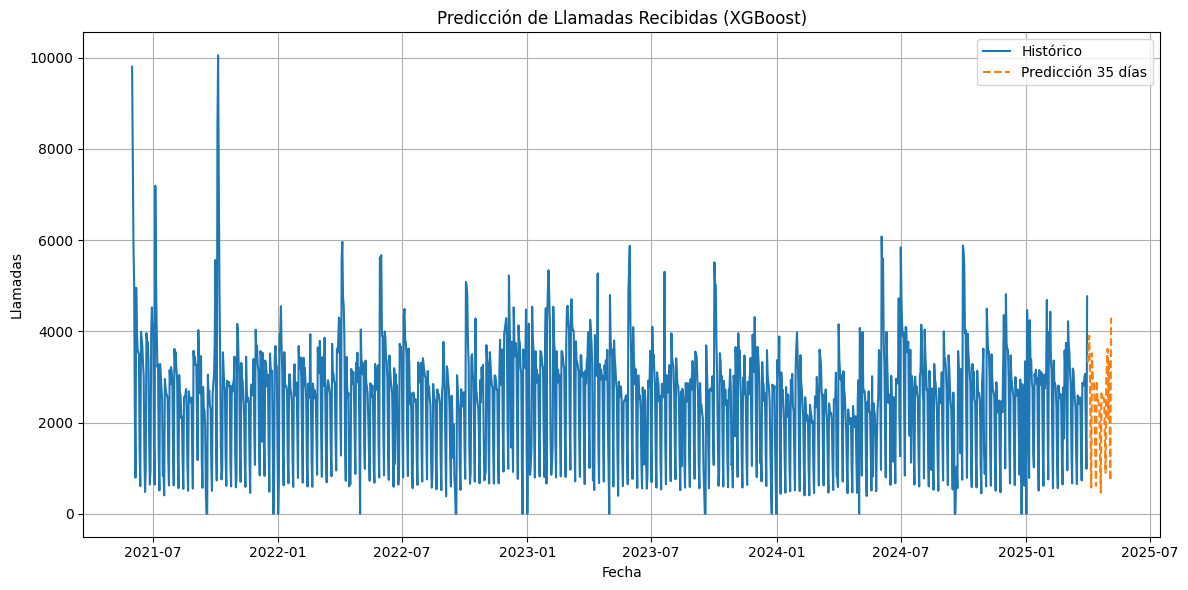

In [ ]:
# Mostrar predicciones
print(df_futuro[['Fecha', 'Llamadas_Predichas']])

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df['Fecha'], df['Llamadas_Recibidas'], label='Histórico')
plt.plot(df_futuro['Fecha'], df_futuro['Llamadas_Predichas'], label='Predicción 35 días', linestyle='--')
plt.title('Predicción de Llamadas Recibidas (XGBoost)')
plt.xlabel('Fecha')
plt.ylabel('Llamadas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Asegúrate de tener estas dos columnas
y_real = df['Llamadas_Recibidas']
y_pred = df['Llamadas_Predecidas']

# Calcular métricas
mae = mean_absolute_error(y_real, y_pred)
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2 = r2_score(y_real, y_pred)

print("\n📊 Evaluación del modelo en datos reales:")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")
print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
print(f"R² (Coeficiente de determinación): {r2:.4f}")


📊 Evaluación del modelo en datos reales:
MAE (Error Absoluto Medio): 494.92
RMSE (Raíz del Error Cuadrático Medio): 723.73
R² (Coeficiente de determinación): 0.6641


In [12]:
# Evaluar el modelo en datos de validación cruzada
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Validación cruzada con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

print(f"MAE promedio: {np.mean(mae_scores):.2f}")
print(f"RMSE promedio: {np.mean(rmse_scores):.2f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")

MAE promedio: 558.48
RMSE promedio: 802.88
R² promedio: 0.5197


In [13]:
df.head(1400)

,Fecha,Llamadas_Predecidas,Llamadas_Recibidas,Es_Cyber,anio,mes,dia,dia_semana,fin_de_semana,es_feriado,es_laboral
0,2021-06-01,5328,9800,1,2021,6,1,1,0,0,1
1,2021-06-02,5114,7687,1,2021,6,2,2,0,0,1
2,2021-06-03,4906,5895,0,2021,6,3,3,0,0,1
3,2021-06-04,4534,5045,0,2021,6,4,4,0,0,1
4,2021-06-05,1757,2228,0,2021,6,5,5,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1395,2025-03-27,3701,2989,0,2025,3,27,3,0,0,1
1396,2025-03-28,3826,3067,0,2025,3,28,4,0,0,1
1397,2025-03-29,1356,1990,0,2025,3,29,5,1,0,0
1398,2025-03-30,660,987,0,2025,3,30,6,1,0,0
